In [9]:
import rdkit
import copy
from rdkit import Chem 
from rdkit.Chem import Draw, Kekulize, SanitizeMol
from rdkit.Chem.rdmolops import CombineMols
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.error')

In [24]:
def idx_annotate(x):
    """
    Taken from: https://iwatobipen.wordpress.com/2017/02/25/draw-molecule-with-atom-index-in-rdkit/
    
    Add label to each molecule's atom: "atom_name:atom_index"
    """
    mol = copy.deepcopy(x)
    for idx in range(mol.GetNumAtoms()):
        mol.GetAtomWithIdx(idx).SetProp(
            'molAtomMapNumber', 
            str(mol.GetAtomWithIdx(idx).GetIdx())
        )
    return mol

def mol(x) : 
    return Chem.MolFromSmiles(x)

def draw(x) : 
    if type(x) == str : x = mol(x)
    Draw.MolToImage(x).show()

def auto_add(x, y, manual_select=False) : 
    if type(x) == str : x = mol(x)
    if type(y) == str : y = mol(y)
    
    combo = CombineMols(x, y) 
    output = []
    add_atom = None

    if manual_select : 
        draw(idx_annotate(x))
        add_atom = int(input("Select atom to add to: "))

    for i in range(x.GetNumAtoms()) :
        if add_atom is not None: i = add_atom
        for j in range(x.GetNumAtoms(), combo.GetNumAtoms()) :
            for b in [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE] :
                combo_editable = Chem.EditableMol(combo)
                combo_editable.AddBond(i, j, order=b)

                try : 
                    Chem.SanitizeMol(combo_editable.GetMol())
                    output.append(Chem.MolToSmiles(combo_editable.GetMol()))
                except : pass
        if add_atom is not None: break
    return output

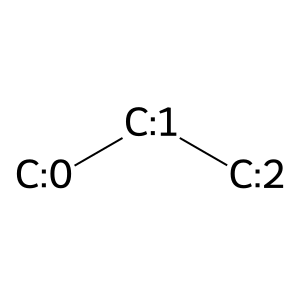

In [25]:
purine = Chem.MolFromSmiles('CCC')
addition = Chem.MolFromSmiles('CCO')

output = auto_add(purine, addition, True)

In [26]:
for i in output : 
    print(i)

CCCCCO
CCC=CCO
CCC#CCO
CCCC(C)O
CCC=C(C)O
CCCOCC


In [23]:
print(None == None)

True
